# New school VS Old School HipHop Which is better? Is there any difference?

You can often hear that there is a difference between old school & new school Hip Hop, many argue that old school Hip Hop is better and many argue otherwise.

![alt text](https://cdn-images-1.medium.com/max/800/1*X9WzT11cauXIlwL7tGmpvw.jpeg "Logo Title Text 1")


Today I'll try to answer the first question - Is there a difference between old school & new school Hip Hop?<br/>
I'll focus on the difference in the lyrics.


I'll start with some simple lyrics analysis, then I'll try to teach a model to distinguish between old school and new school lyrics and finally we will interpret the model's decisions.<br/>
**I won't use any word embedding because I want my model to be easly interpretable.**



For this experiment I picked around 60 rappers, some from the old school and some from the new school.<br/>
I used the [Genius API](https://docs.genius.com/) to extract the songs' webpages and then html parsers to extract the lyrics  themselves.<br/>
I've built a wrapper around the API for this use, you can check it out in this [GitHub page](https://github.com/arielszabo/Old_n_New_School_Rap/blob/master/GeniusLyrics_Scraper.py)



#### Enough talking, let's start working:

- Cleaning data:
    - clean strage lyrics like skits, snippet and non-english ...
    - clean outliers like high/low word count songs
    - duplicate data
    - clean the lyrics themselves
- EDA:
    - word cloud
    - song length
- ML:
    - Kfold & GridSearch
- Eli5 for model interpretability

## Analysis

In [1]:
# Load our modules and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%matplotlib inline
sns.set()
np.random.seed(1)
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel(r'lyrics2.xlsx')
data.head()

,song_url,lyrics,artist,rapper_type
0,https://genius.com/Jay-z-03-bonnie-and-clyde-l...,"\n\n[Intro: Jay Z]\nUhh, uhh, uhh\nYou ready, ...",2pac,old_school_rappers
1,https://genius.com/2pac-16-on-death-row-lyrics,\n\n[Intro]\nDeath Row\nThat's where mothafuck...,2pac,old_school_rappers
2,https://genius.com/Bknappbeats-16-on-death-row...,\n\n[Verse 1]\nI'm caught up in this sickness\...,2pac,old_school_rappers
3,https://genius.com/2pac-187-on-a-hook-remix-ly...,"\n\n[Hook: C-Bo] (2X)\nWest side, it's 187 on ...",2pac,old_school_rappers
4,https://genius.com/2pac-1995-police-station-te...,"\n\nWoman – Sir, will you raise your right han...",2pac,old_school_rappers


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14663 entries, 0 to 14662
Data columns (total 4 columns):
song_url       14663 non-null object
lyrics         14663 non-null object
artist         14663 non-null object
rapper_type    14663 non-null object
dtypes: object(4)
memory usage: 572.8+ KB


## Cleaning the lyrics:
After I've viewd some lyrics I have some notes about cleaning the data:
1. The rappers names are writen between square brackets - "[]". **I would like to delete this.**
2. Sometimes we can see lyrics between brackets. Sometimes it is part of the song but sometimes it's not. **I'll delete this for now**
3. There is a lot of spelling errors and slang abbreviations! **I'll deal with some of it later"**
4. There are some real strange lyrics which I'm not sure how I got them, like lyrics with full Asian or Arabic charachters, lyrics with no words or a line that say there is no lyrics etc. **We'll try to locate them and delete them**

The next lines of code generates a random line in data.<br/>
Then we print it's lyrics and it's url (It can help if you want to view more about the lyrics)

In [4]:
random_url, random_lyrics = data[['song_url', 'lyrics']].sample(1).values[0]
print(random_url)
print(random_lyrics)

https://genius.com/Mac-miller-face-the-facts-lyrics


[Intro]
Just a display of rhyme skill man, that's what it is

92 Till Infinity and beyond and beyond

Alright look, muthafucka still rap, biatch !

[Verse 1: Mac Miller]
Hey, when I was 15 it was my dream to work with Preem
He believe in what I do, so now he's makin' this beat
And I'm writin' these rhymes, makin' sure that I kill it
Shinin' like I'm acrylic, the government can't conceal it
My style they tried to steal it, cause people startin' to feel it
I'm goin' on these adventures, somethin' like on a field trip
And now I'm growin' up, lookin' around this planet
Some shit be goin' on and I just can't understand it
No need to panic, I, got it expanded
Is a million downloads I'm takin' over ya bandwidth
Moments all candid, Kodak,reminisce and go back
Life real good want ya'll to know that
Don't have no deal and no half a mill
Just on my Gang Starr shit with some Mass Appeal
Go platinum independently, incredibly dope
You need a tele

### Find strange and ood lyrics
In this section I'll find some odd and strange lyrics. Lyrics that ruin our data.
We'll collect them and at the end we will drop them.<br/>
If we are tring to classify rap lyrics we need our data to have proper rap lyrics.<br/>
No snippets, No skits, nor anything like that. In our case I'll call this kind of bad data an outlier.


As I was looking at the lyrics I found some [skits](https://en.wikipedia.org/wiki/Hip_hop_skit) between our lyrics.<br/>
This is something we don't want in our data:

In [5]:
skit_songs = data[data.song_url.str.contains('skit', case=False)]

Similarly to the skits I found snippet lyrics. <br/>
It's some times written in the actual url and some times it's in the lyrics themselves (with square brackets or with the * symbol around them).

In [6]:
all_snippet = data[
    data.song_url.str.contains('Snippet', case=False) | data.lyrics.str.contains('[\*\[]Snippet[\*\]]', case=False) 
                  ] # This pipe ("|") is an OR

Actually all the song url without the word 'lyrics' are not actual lyrics but something strage. Drop them !

In [7]:
no_lyrics_in_url = data[~data.song_url.str.contains('lyrics', case=False, regex=False)]

There can be other outliers like lyrics with no english (I saw at least one like this)

In [8]:
no_english_lyrics = data[~data.lyrics.str.contains(r'[A-Za-z]')]

I also encountered some lyrics which are just credits:

In [43]:
credits_urls = data[data.song_url.str.contains('credits', case=False, regex=False)]

# Outliers
If we have already started talking about outliers, let's look at them a bit more.
Can a rap song be without lyrics at all? What ?!? A rap song with no words? interesting ... maybe it's an outlier ?

Let's create a feature of the amout of words in a song.

In [9]:
data['word_count'] = data['lyrics'].apply(lambda lyrics: len(lyrics.split()))

Songs with no words (word_count == 0) are clearly outliers, they are just wrong entities. **I'll drop them**<br/>
But what about higher values? or really small ones?

In descriptive statistics, a [box plot](https://en.wikipedia.org/wiki/Box_plot) is a method for graphically depicting groups of numerical data through their quartiles.<br/>
Box plots help us discover outliers in a distribution by a method called [IQR](https://en.wikipedia.org/wiki/Interquartile_range).<br/>
I won't get into how they decide which data point is an outlier (go ahead and read more about IQR [here](https://en.wikipedia.org/wiki/Interquartile_range)).<br/>
The points in the plot represent outliers based on the IQR calculation:

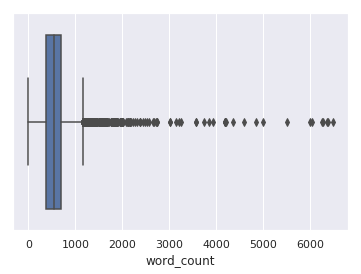

In [10]:
sns.boxplot(x="word_count", data=data);

Looks like a song with a little above 1000 words is considered to be an outlier.<br/>
let's plot the boxplot without them and show them as well:

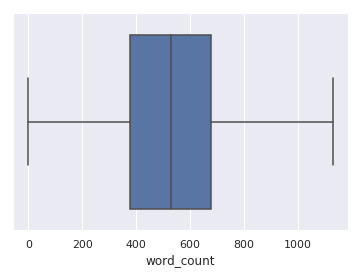

In [11]:
sns.boxplot(x="word_count", data=data[data.word_count < 1130]);

In [12]:
high_word_count = data[data.word_count > 1130]
high_word_count.head()

,song_url,lyrics,artist,rapper_type,word_count
19,https://genius.com/2pac-2pac-cypher-part-2-lyrics,\n\n[Verse 1 Redman]\n\nTry to O.K. Corral wit...,2pac,old_school_rappers,1411
62,https://genius.com/Muslim-all-eyes-on-me-lyrics,"\n\nParoles de Muslim ""All Eyes On Me""[Intro]\...",2pac,old_school_rappers,1183
77,https://genius.com/Young-lay-amerikka-eatz-itz...,"\n\n[Intro: Khayree]\nAwhh yeah, break me off ...",2pac,old_school_rappers,1215
89,https://genius.com/2pac-and-outlawz-as-the-wor...,\n\n[Intro: 2Pac]\nAs the world turns…\nAs the...,2pac,old_school_rappers,1162
90,https://genius.com/2pac-as-the-world-turns-og-...,\n\n[Intro: 2Pac]\nAs the world turns…\nAs the...,2pac,old_school_rappers,1147


From a quick look at some of the "lyrics" and relevant webpages I saw there is some interviews mixed up in this data. I think we can safely remove all "songs" with 1300 words and above ! (We still have a lot of data so we don't need to mind that so much)

**But what about low count of words?**<br/>
The box plot didn't alert any low count to be an outlier but as I looked at the data I saw there are songs which have it written that there is no lyrics for this song. This kind of songs will have low count of words.
In addition I have never seen a rap song with only one word...

So even though based on the IQR calculation there are no low count outliers we would look at some low word count songs:

In [13]:
low_word_count = data[data.word_count < 50]
low_word_count.head()

,song_url,lyrics,artist,rapper_type,word_count
58,https://genius.com/2pac-album-outro-lyrics,\n\n[Outro]\nExpect me nigga like you expect J...,2pac,old_school_rappers,31
71,https://genius.com/2pac-ambition-over-adversit...,\n\nTake ones adversity\nLearn from their misf...,2pac,old_school_rappers,25
87,https://genius.com/2pac-a-river-that-flows-for...,\n\nAs long as some suffer\nThe River Flows Fo...,2pac,old_school_rappers,44
182,https://genius.com/2pac-cupids-smile-ii-annotated,\n\nI ran outside 2 feel the rain\nand I staye...,2pac,old_school_rappers,26
200,https://genius.com/Akon-dj-vlad-16-on-death-ro...,\n\n[Intro: 2Pac]\nDeath row\nThat's where mot...,2pac,old_school_rappers,21


## Let's look at duplicate data:
Songs may have more than one rapper, so we can encounter duplicates.<br/>
A duplicate in this case is when we have more than one rapper with the same lyrics and song url (If it's the same song it should have the same url for lyrics).

I'll group songs with the same lyrics. If there is more than one unique url for a unique lyrics, I would want to take further look:

In [50]:
data[data.duplicated(subset=['lyrics'], keep=False)].sort_values('lyrics').head()

,song_url,lyrics,artist,rapper_type,word_count
10506,https://genius.com/Tony-whlgn-joey-bada-x-ab-s...,\n\n\n\n,Joey Bada$$,new_school_rappers,0
5490,https://genius.com/Gordon-parks-a-great-day-in...,\n\n\n\n,Wu-Tang Clan,old_school_rappers,0
10486,https://genius.com/Theillustrator-happy-1999-d...,\n\n\n\n,Joey Bada$$,new_school_rappers,0
3734,https://genius.com/Beastie-boys-hello-nasty-al...,\n\n\n\n,Beastie Boys,old_school_rappers,0
1528,https://genius.com/Ice-cube-death-certificate-...,\n\n\n\n,Ice Cube,old_school_rappers,0


It seems that the duplicate lyrics are most of the times different versions of the song or empty lyrics.

Because I'm intrested in the actual song lyrics and I don't need two songs with the same lyrics, I'll drop one of them.

# Drop the outliers and bad data:

In [207]:
clean_data = data .copy()
# Drop all the strange, ood, snippet, skit data etc ...
bad = pd.concat([skit_songs, all_snippet, no_lyrics_in_url, no_english_lyrics, credits_urls])
clean_data.drop(set(bad.index), inplace=True)


# Drop high word count
clean_data.drop(clean_data.query('word_count > 1300').index, inplace=True)

# Drop low word count
clean_data.drop(clean_data.query('word_count < 50').index, inplace=True)

# Drop one of the duplicates
clean_data.drop_duplicates(subset=['lyrics'], inplace=True)

In [208]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12465 entries, 0 to 14662
Data columns (total 5 columns):
song_url       12465 non-null object
lyrics         12465 non-null object
artist         12465 non-null object
rapper_type    12465 non-null object
word_count     12465 non-null int64
dtypes: int64(1), object(4)
memory usage: 584.3+ KB


So after all the cleaning bad data we got from 14663 song lyrics to 12465 (85% of the original data).

In [209]:
# This function gets a raw lyrics string and returns it cleaned after the steps described:
def clean_song_lyrics(raw_song_lyrics):
    # lower-case all lyrics:
    song_lyrics = str(raw_song_lyrics).lower()
    # change the \n to a space
    song_lyrics = re.sub(r'(\n)', ' ', song_lyrics)
    # Remove text between brackets:
    song_lyrics = re.sub(r'\([^\(\)]+\)', '', song_lyrics)
    # Change "$" in a middle of a word to "s":
    song_lyrics = re.sub(r'\w+(\$)\w+', 's', song_lyrics)
    # all the I'm combinations we will convert to "I am". It seems "I" is something significant:
    song_lyrics = re.sub(r'\W(i.m)\W', 'i am', song_lyrics)
    # Remove irrelevant text between square brackets like rappers names and verse number ...:
    song_lyrics = re.sub(r'\[[^\[\]]+\]', '', song_lyrics)
    # Remove anything that is not a word, a number or white-space (like ' and ?)
    song_lyrics = re.sub('[^\w\s]', '', song_lyrics)
    return song_lyrics

In [210]:
clean_data['clean_lyrics'] = clean_data['lyrics'].apply(clean_song_lyrics)

In [211]:
all_lyrics_dirty = ' '.join(clean_data['lyrics'])
set(re.findall(r"\b(i.m)\b", all_lyrics_dirty))

{"i'm", 'i`m', 'ihm', 'inm', 'ism', 'ium', 'izm', 'i´m', 'i¹m', 'i’m'}

In [212]:
all_lyrics_clean = ' '.join(clean_data['clean_lyrics'])
set(re.findall(r"\b(i.m)\b", all_lyrics_clean))

{'i m', 'iam', 'ikm', 'imm'}

#### Clean slangs:

In [213]:
slang_word_convertor = {
    "aint":"are not",
    "cause":"because",
    "wanna":"want to",
    "cmon":"come on",
    "em":"them",
    "yeah":"yes",
    "gotta":"got to",
    "yall":"you all",
    "ya":'you',
    'ho':'hoe',
    "gon":"going to",
    "gonna":"going to",
    "lil":"little",
    "fuckin":"fucking",
    "motherfuckin":"motherfucking",
    "gettin":"getting",
    "tryna":"trying to",
    "bout":"about",
    "ima":"i am going to",
    "wit":"with",
    "imma":"i am going to",
    "til":"until",
    "talkin":"talking",
    "gangsta":"gangster",
    "comin":"coming",
    "homie":"home boy",
    "livin":"living",
    "runnin":"running",
    "smokin":"smoking",
    "rollin":"rolling",
    "makin":"making",
    "thang":"thing",
    "ridin":"riding",
    "lookin":"looking",
    "gimme":"give me",
    "takin":"taking",
    "playin":"playing",
    "poppin":"popping",
    "sayin":"saying",
    "thinkin":"thinking",
}


In [214]:
for key, value in slang_word_convertor.items():
    clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W({key})\W', f' {value} ')

Some times I can see rappers names in the lyrics.<br/>
I'll remove these names so the model won't learn anything from there apperence.

In [215]:
for artist_name in set(clean_data.artist):
    for part_of_artist_name in artist_name.lower().split():
        if len(part_of_artist_name) > 1:
            clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W({part_of_artist_name})\W', ' ')
# custom clean names
clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W(bad boy)\W', ' ')
clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W(queen bee)\W', ' ')
clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W(weezy)\W', ' ')
clean_data['clean_lyrics'] = clean_data['clean_lyrics'].str.replace(f'\W(tupac)\W', ' ')


In [233]:
clean_data[clean_data['clean_lyrics'].str.contains('\Wweezy\W', regex=True)]

,song_url,lyrics,artist,rapper_type,word_count,clean_lyrics
12972,https://genius.com/Lil-wayne-500-degreez-lyrics,"\n\n[Lil Wayne talking]\nIt's the real shit, y...",Lil Wayne,new_school_rappers,570,its real shit yes 500 degreez this time bio...
13006,https://genius.com/Sqad-up-all-i-know-lyrics,"\n\n[Intro: Lil Wayne, Ad lib]\nSqad up nigga!...",Lil Wayne,new_school_rappers,867,sqad up nigga what you thought it was you k...


In [234]:
clean_data.loc[12972].lyrics

'\n\n[Lil Wayne talking]\nIt\'s the real shit, yeah\n500 Degreez this time biotch\nYes sir, you already know\n\n[Lil Wayne verse 1]\nYou see me? I eat, sleep, shit, and talk snaps; so fuck rap\nMan I got weed, pills, pistols, all crack\nBitch niggas where ya hearts at?\nYa\'ll ain\'t stuntin\' like us\nBitch niggas where ya cars at?\nThey like, "Wayne why the fuck you dressed in all black?"\nI\'m about to bring CMR back\nAnd all the lames, we done lost that\nAnd all we got is Weezy, Weezy, and Lil\' Weezy to fall back\nI\'m about to lock it from the summer to the fall and back\n"Its Weezy baby!" The ballers back\nAnd the wheels on my car you got all of that\nStop playing, I\'ve been balling jack\nYou don\'t want my Glock spraying - I hit all them cats\nYou don\'t want my stomach ache - I shit on them cats\nI get all them gats - Fresh and B it\'s all a rap!\nIf I\'m the only Hot Boy what do you call that?\n\n[Hook]\nYou don\'t want to fuck with Weezy\nYou don\'t want to fuck with Weezy\

In [235]:
clean_data.loc[12972].clean_lyrics

'   its real shit yes 500 degreez this time biotch yes sir you already know   you see me i eat sleep shit and talk snaps so fuck rap man i got weed pills pistols all crack bitch niggas where you hearts at you all are not stuntin like us bitch niggas where you cars at they like why fuck you dressed in all blacki amabout to bring cmr back and all lames we done lost that and all we got is weezy and little to fall backi amabout to lock it from summer to fall and back its baby ballers back and wheels on my car you got all of that stop playing ive been balling jack you dont want my glock spraying  i hit all them cats you dont want my stomach ache  i shit on them cats i get all them gats  fresh and b its all a rap ifi amthe only hot boy what do you call that   you dont want to fuck with you dont want to fuck with   bitch what ill bust you ass up dont even go there round niggas get your cash up we probably need to clash up and shit got me about ass up they finding niggas in they shit with they

After this clean up we can go ahead and **get to know our data better**:<br/>
start by simply ploting the amout of full song lyrics we have from each type of "rapper_type":

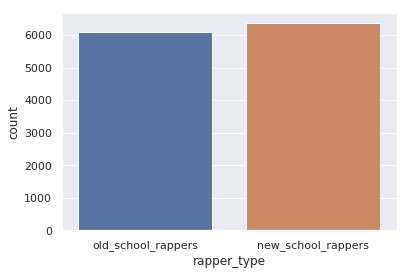

In [219]:
sns.countplot(data=clean_data, x='rapper_type');

There is a little more new school rappers lyrics than old school ones but **it's not significant**.

### But wait a minute ! Who are the rappers?

In [220]:
for school in ['new_school_rappers', 'old_school_rappers']:
    rappers_songs = clean_data[clean_data.rapper_type == school].artist.value_counts()
    print(f"These are the {len(rappers_songs)} {school} and how much songs they have:")
    print(rappers_songs)
    print('\n')

These are the 28 new_school_rappers and how much songs they have:
Fetty Wap             285
Tyler, the Creator    273
Wiz Khalifa           270
Nicki Minaj           261
Lupe Fiasco           261
Mac Miller            260
Schoolboy Q           259
Chance The Rapper     259
Big Sean              258
J. Cole               257
Drake                 257
Joey Bada$$           256
Lil Uzi Vert          256
Logic                 255
Future                254
Travis Scott          252
A$AP Rocky            251
Pusha-T               247
The Game              246
Lil Wayne             235
2 Chainz              231
Kendrick Lamar        223
Rick Ross             208
Kanye West            202
LIL PUMP              107
Cardi B                85
Rae Sremmurd           80
Joyner Lucas           77
Name: artist, dtype: int64


These are the 29 old_school_rappers and how much songs they have:
Jay-Z                   280
Snoop Dogg              278
LL Cool J               276
Mobb Deep               272

## Word Cloud
Word cloud is a nice way to plot frequent words

In [221]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud_plot(text):
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", scale=3).generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(55, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()

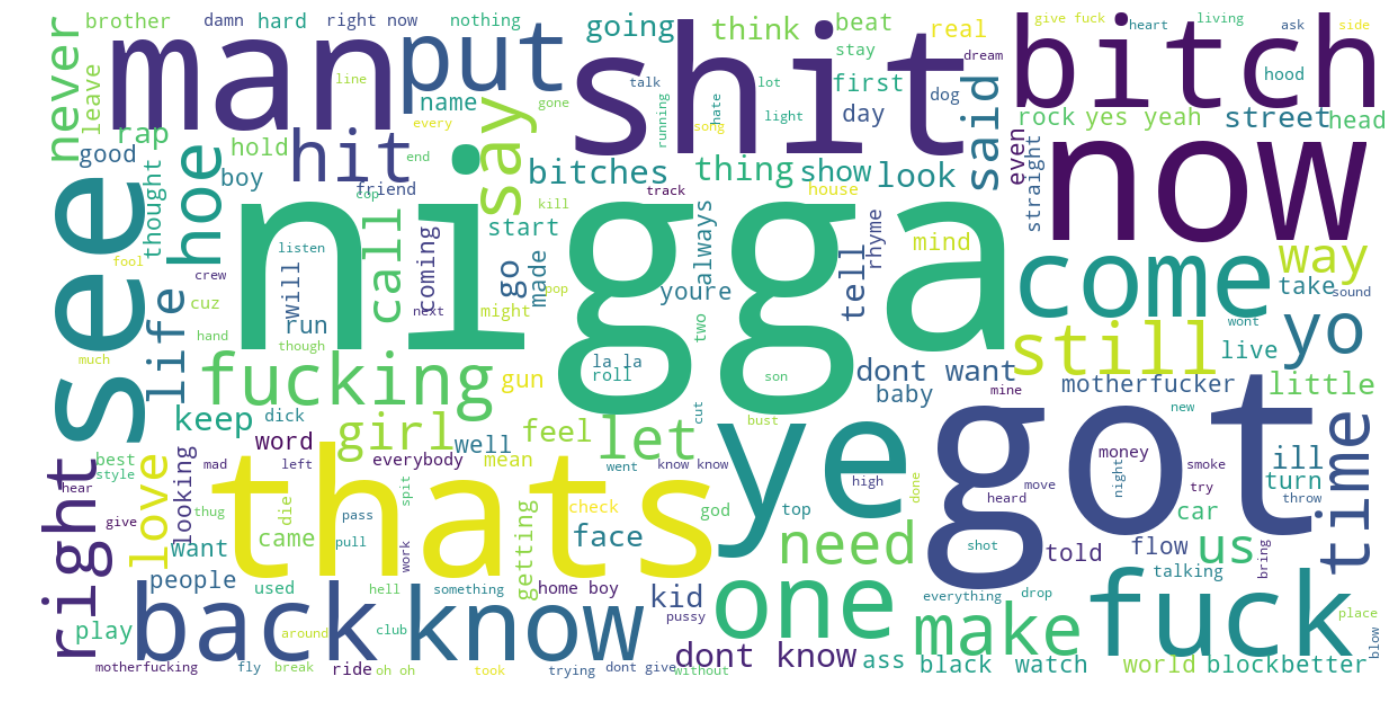

In [222]:
all_lyrics = ' '.join(clean_data['clean_lyrics']).replace('\n', ' ')
word_cloud_plot(all_lyrics)

## Is there difference in the legth of the songs?
We will masure length by the number of words

In [223]:
clean_data.groupby('rapper_type')['word_count'].agg(['mean', 'std', 'median', 'min', 'max'])

,mean,std,median,min,max
rapper_type,,,,,
new_school_rappers,523.971720,213.915454,516,50,1299
old_school_rappers,564.329344,223.306343,562,51,1299


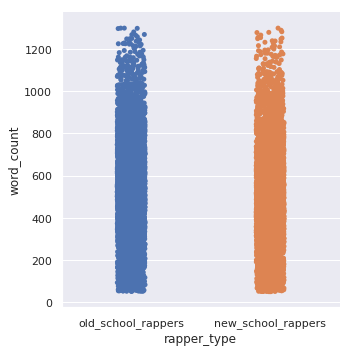

In [224]:
sns.catplot(x="rapper_type", y="word_count", data=clean_data);

I don't think we can find any real significant difference in the word count.


I think it's time to start building our model

# ML model building

In [225]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
# from dask_searchcv import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from ariels_utils import MLTester
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
import datetime
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
import gensim
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ariel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [226]:
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy


class CustomVectorizer(CountVectorizer):

    def _lemmatize_stemming(self, word):
        lemma_= WordNetLemmatizer().lemmatize(word, pos='v')
        return SnowballStemmer(language='english').stem(lemma_)

        # create the analyzer that will be returned by this method
    def custom_analyzer(self, doc):
        # apply the preprocessing and tokenzation steps
        lemmatized_tokens = []
        for token in gensim.utils.simple_preprocess(doc):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                lemmatized_tokens.append(self._lemmatize_stemming(token))

        # use sklearn-vectorizer's _word_ngrams built in method
        # to remove stop words and extract n-grams
        return self._word_ngrams(lemmatized_tokens, self.get_stop_words())

    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
    def build_analyzer(self):
        return self.custom_analyzer


In [227]:
X = clean_data['clean_lyrics']
y = clean_data['rapper_type']

In [228]:
# model = Pipeline(
#         [
# #             ('vec', CustomVectorizer(binary=True, stop_words='english')),
#             ('vec', TfidfVectorizer(tokenizer=lambda line: list(map(SnowballStemmer('english').stem, line.split()))
#                                    )),
# #             ('vec', TfidfVectorizer()),
# #             ('minmax', MaxAbsScaler()),
# #             ('SGD', SGDClassifier(loss='log', penalty='l1', alpha=0.0001, l1_ratio=0.3,
# #                                   max_iter=1000, epsilon=0.1, n_jobs=-1,
# #                                   learning_rate='optimal', eta0=0.0, power_t=0.0,
# #                                   early_stopping=True, validation_fraction=0.15, n_iter_no_change=5))
# #             ('dense_convert', FunctionTransformer(lambda x: x.toarray(), validate=False)),
# #             ('FA', FeatureAgglomeration(n_clusters=1000)),
# #             ('logreg', LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=0.1, max_iter=100))
#             ('select', SelectKBest(f_classif, k=200)),
# #             ('logreg', LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=0.1, max_iter=100))
#             ('SVM', LinearSVC())
# #             ('xgb', xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, silent=True,
# #                                       objective='binary:logistic', booster='gblinear', n_jobs=-1, nthread=None,
# #                                       gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1,
# #                                       colsample_bylevel=1, reg_alpha=0, reg_lambda=1))
#         ]
#     )

In [229]:
model = Pipeline(
        [
            ('vec', TfidfVectorizer(tokenizer=lambda line: list(map(SnowballStemmer('english').stem, line.split()))
                                   )),
            ('select', SelectKBest(f_classif, k=200)),  # use top 200 word features (this is just for simplicity)
            ('SVM', LinearSVC())
        ]
    )

In [230]:
%%time
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
print(metrics.accuracy_score(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train))
y_pred = model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.8180359435173299
                    precision    recall  f1-score   support

new_school_rappers       0.80      0.86      0.83      4773
old_school_rappers       0.84      0.78      0.81      4575

         micro avg       0.82      0.82      0.82      9348
         macro avg       0.82      0.82      0.82      9348
      weighted avg       0.82      0.82      0.82      9348

0.7972409367982034
                    precision    recall  f1-score   support

new_school_rappers       0.79      0.83      0.81      1592
old_school_rappers       0.81      0.77      0.79      1525

         micro avg       0.80      0.80      0.80      3117
         macro avg       0.80      0.80      0.80      3117
      weighted avg       0.80      0.80      0.80      3117

CPU times: user 2min 8s, sys: 31.7 ms, total: 2min 8s
Wall time: 2min 8s


In [ ]:
%%time
scores = cross_val_score(model, X, y, verbose=1, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), n_jobs=-1)
print(scores.mean())

I did a Repeated Stratified KFold test with 5 fold which where repeated 5 times (total 25 runs). 

# Interpret the model's decisions
Let's look at the top 25 features which helped the model decide.

The green words are the words (features) which turned the model towards "old school" and the red ones turned towards "new school" 

In [231]:
import eli5
eli5.show_weights(model,top=25)

Weight?,Feature
+5.144,thug
+4.565,homeboy
+2.988,player
+2.949,tryin
+2.882,funki
+2.882,wu
+2.850,sucker
+2.802,x
+2.722,punk
+2.686,peep


**btw I think old school hip hop is better**